In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# 와인 리뷰데이터 불러오기
wine_original = pd.read_csv('winemag-data-130k-v2.csv', encoding='utf-8')

## wine_review Data Information

<br/>

- country 와인생산국
- description 맛, 와인에 대한 리뷰(평론)
- points  점수(평론가 평가 점수)
- price 가격
- province 포도생산지
- region_1 / region_2 포도 생산지에 대한 세밀한 지역
- taster_name 평론가 이름
- taster_twitter_handle 평론가 트위터 주소
- title 와인 이름, 생산 연도별 묶음
- variety 포도 품종
- winery 와인생산지(양조장)

<br/>

## country, province, region. winery에 대한 정보

<br/>

와인 이름을 짓는 여섯가지 방식
1. 양조장(포도원) 명칭
2. 생산지명
    - 생산지명 + 와인생산자, 양조장
3. 와인회사명
    - 와인회사명 + 포도종류
<br/>
    - 와인회사명 + 생산지명
4. 상표
    - 상표 + 포도종류
<br/>
    - 상표 + 생산지명
5. 포도품종( + 양조장)
6. 전설이나 일화에서 유래한 이름

<br/>

## 목표
- 전제 : 한정된 시간과 정보로 주요한 사용자의 정보(input) 값으로 보다 정확성이 높게 와인 추천 데이터(output) 도출
    - 데이터 전처리를 통하는 과정에서 주요 부분을 체크하고 해당 정보를 입력받아 추천해주는 형식으로 진행

In [ ]:
wine_original.info()

In [ ]:
wine_original.isnull().sum()

---
> <span style='font-size:20pt;'>Taster 버리기 및 열 분포</span>
---

<br/>
- 포도 품종을 기준으로 갯수 상위 20개의 품종만 선택<br/>
- Unnamed: 0, region_2, taster_twitter_hanlde 열 삭제<br/>
- price, designation, region_1 null data : title에서 규착을 찾아서 결측치 보완 >  삭제<br/>
    - designation, province 같이 null 값인 행 삭제<br/>
- year : title에서 생산연도 파싱해 열 추가<br/>
- country, province null data : crawling을 통해 결측치 보완<br/>
    - 행을 삭제하는 과정에서 결측치 삭제됨<br/>
- taster_name : 나라마다 가장 많은 리뷰를 남긴 taster로 예측해 결측치 보완

In [ ]:
wine = wine_original.copy()

In [ ]:
# 불필요한 열 삭제
# Unnamed: 0, region_2, taster_twitter_hanlde 열

del wine['Unnamed: 0']
del wine['region_2']
del wine['taster_twitter_handle']

# wine_rv.drop(["Unnamed: 0", "region_2", "taster_twitter_handle"], axis = 1, inplace = True)

In [ ]:
# 포도 품종을 기준으로 상위 20개의 품종만 선택
wine = wine[ wine['variety'].isin( wine['variety'].value_counts()[:20].index) ]

In [ ]:
# price null data 삭제

wine = wine.loc[ wine['price'].notnull() ]

# drop_price_index = wine_rv[wine_rv["price"].isnull()].index
# wine_rv.drop(drop_price_index, inplace = True)

In [ ]:
# designation, region_1 null data : title에서 규착을 찾아서 결측치 보완 > 삭제
#     -designation, province 같이 null 값인 행 삭제
wine = wine[ wine['province'].notnull() & wine['region_1'].notnull() ]
wine = wine[ wine['designation'].notnull() & wine['region_1'].notnull() ]

---
> <span style='font-size:20pt;'>Review Data Tokenizing</span>
---

In [ ]:
# 명사, 형용사만을 리스트에 담고, 그 리스트를 하나의 String으로 합쳐서 내주는 함수
import nltk
import re

def text_cleaning(data):
    
    # 정규표현식으로 알파벳만을 남김
    text = re.sub('[^a-zA-Z]', ' ', data)
    
    # 문자열을 소문자로 바꾸고, 단어를 tokenize pos tagging 품사를 결정해줌
    text_lower = text.lower()
    text_tokens = nltk.word_tokenize(text_lower)
    text_pos = nltk.pos_tag(text_tokens)
    
    # 품사가 N,J로 시작하는 단어에 대해서, 원형으로 바꾸고 list에 담음
    word_lemma = []
    wnlm = nltk.WordNetLemmatizer()
    for word, pos in text_pos:
        if pos.startswith('N'):
            word_lemma.append( wnlm.lemmatize(word, pos='n') )
        elif pos.startswith('J'):
            word_lemma.append( wnlm.lemmatize(word, pos='a') )
    
    # 합쳐서 return 해줌
    return ' '.join(word_lemma)

In [ ]:
# 모든 데이터에 대헤서 위의 과정을 거침
result = []

for idx, x in enumerate(wine['description']):
    result.append(text_cleaning(x))
    
wine = wine.reset_index(drop=True)
wine['description'] = pd.Series(result)

In [ ]:
# title에서 생산연도(year) 파싱해 열 추가
import re

pattern = re.compile(r'\d{4}')
wine['year'] = wine['title'].apply(
    lambda x : int(pattern.search(x).group()) if pattern.search(x) else None )

---
> <span style='font-size:20pt;'>결측치 채우기</span>
---

In [ ]:
# 결측치 제거 및 nltk 전처리 진행한 데이터 내보내기
wine.to_excel('wine_stemming.xlsx',encoding='utf-8', index=False)

In [ ]:
# 결측치 제거 진행한 데이터 불러오기
wine_remove = pd.read_excel('wine_stemming.xlsx', encoding='utf-8')
wine_remove.info()

In [ ]:
wine_remove[wine_remove['country']=='US']['taster_name'].value_counts()
# Virginie Boone        5963
# Paul Gregutt          5625
# Matt Kettmann         3781

In [ ]:
wine_rv_US = wine_remove[wine_remove['country']=='US']
wine_rv_del_US = wine_remove.drop(wine_rv_US.index)

In [ ]:
# taster_name열의 Null값을 Random으로 채움
import random

ran = ['Virginie Boone', 'Paul Gregutt', 'Matt Kettmann']
wine_rv_US['taster_name'] = wine_rv_US['taster_name'].fillna(random.choice(ran))

In [ ]:
# "US" full-data를 합쳐서 중복값 제거
wine_remove = pd.concat([wine_rv_US, wine_rv_del_US], axis=0)

In [ ]:
# 나라 리스트 생성
wine_rv_country = list(wine_remove.groupby('country').groups.keys())

# 예측 방식이 다른 나라 "US" 삭제
wine_rv_country.remove('US')

wine_rv_country

In [ ]:
# 나라마다 가장 많은 리뷰를 남긴 taster_name 리스트 생성
from collections import Counter # 빈도 수를 구해주는 함수

wine_rv_taster_most = {} # "country : taster_name" 형태의 dict
for country in wine_rv_country : 
    counter = Counter(wine_remove[wine_remove['country'] == country]['taster_name'])
    wine_rv_taster_most[country] = counter.most_common(1)[0][0]

wine_rv_taster_most

In [ ]:
wine_remove[wine_remove["taster_name"].isnull()] # 11949

In [ ]:
# 나라마다 비어있는 taster_name에 가장 많은 리뷰를 남긴 taster로 예측해서 값 채우기

# try-except 처리로 full-data 만들기
filled_taster_name = []

for row_idx, row in wine_remove.iterrows():
    try: 
        # taster_name == None이면 실행되는 구문
        float(row['taster_name']) # np.nan 형태로 변경 # None이 아닌 str은 일부러 오류 생성
        filled_taster_name.append(wine_rv_taster_most[row['country']]) # wine_rv_taster_most에서 해당 국가의 값을 가져옴
    except:
        # try 구문의 조건이 아닐경우 오류가 생성되고 except 구문 실행
        filled_taster_name.append(row['taster_name']) # 본래 가지고 있던 값 사용

wine_remove['taster_name'] = filled_taster_name # 새로운 열로 full-data 추가

In [ ]:
# 결측치가 모두 보완된 데이터 내보내기
wine_remove = wine_remove.sort_values(by=['title']).reset_index(drop=True)
wine_remove.to_excel('wine_final.xlsx', encoding = 'utf-8', index = False)

# 추가 전처리, 유사도 계산, 결과

In [2]:
wine = pd.read_excel('wine_final.xlsx', encoding = 'utf-8')

---
> <span style='font-size:20pt;'>Variety 열 분포</span>
---

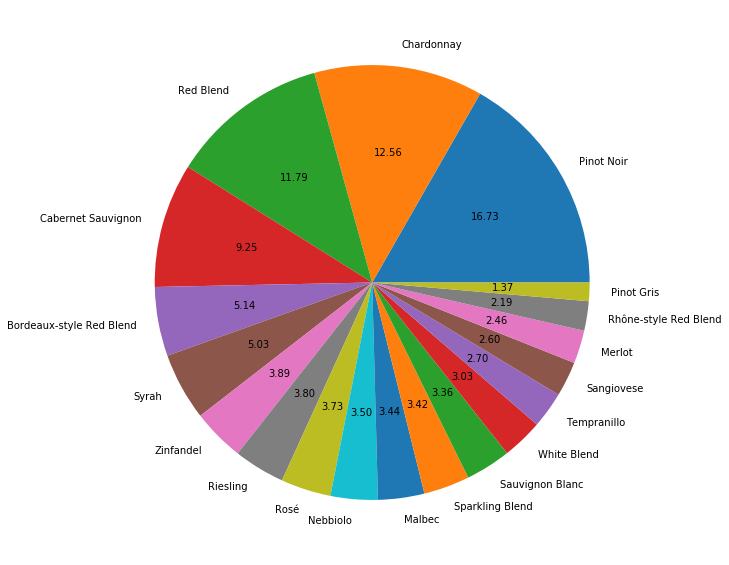

In [3]:
plt.figure(figsize=(10,10))

plt.pie(wine['variety'].value_counts(), labels=wine['variety'].value_counts().index, autopct='%.2f')
plt.show()

---
> <span style='font-size:20pt;'>Country 열 분포</span>
---

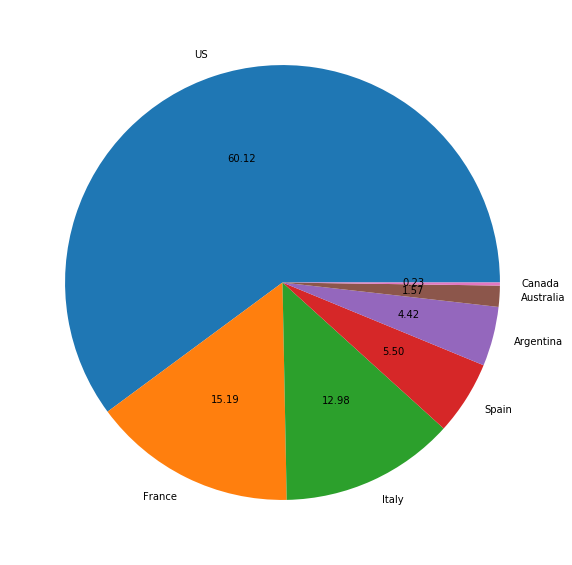

In [4]:
plt.figure(figsize=(10,10))

plt.pie(wine['country'].value_counts(), labels=wine['country'].value_counts().index,
        autopct="%.2f")
plt.show()

---
> <span style='font-size:20pt;'>Taster 버리기 및 열 분포</span>
---

In [5]:
wine = wine[ wine['taster_name'].isin(wine['taster_name'].value_counts()[:-6].index) ]

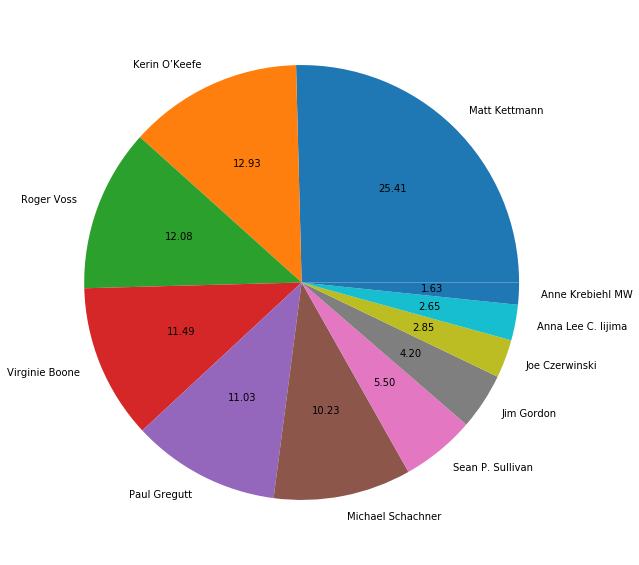

In [6]:
plt.figure(figsize=(10,10))
plt.pie(wine['taster_name'].value_counts(), labels=wine['taster_name'].value_counts().index,
        autopct='%.2f')
plt.show()

---
> <span style='font-size:20pt;'>Country, Vareity, Province열 Labeling</span>
---

In [7]:
from sklearn.preprocessing import LabelEncoder

def data_labeling(key, data):
    le = LabelEncoder()
    le.fit(data[key])
    data[key] = le.transform(data[key])
    return le

le = []
keys = ['country','variety','province']
for key in keys:
    le.append(data_labeling(key, wine))

---
> <span style='font-size:20pt;'>Year 빈열 0으로 채움</span>
---

In [8]:
wine['year'] = wine['year'].fillna(0).astype(int)

---
> <span style='font-size:20pt;'>불용어 사전으로 Description 열 검열</span>
---

In [9]:
stop_words = ["bennett", "pablo", "julius", "belle", "brett", "david", "bello",
    "della", "william", "sigrid", "douglas", "greg", "paul", "dame",
    "anne", "kenneth", "kenny", "pn", "lisa", "jacob", "stewart",
    "rnson", "luigi", "mignon", "donna", "hyde", "corey", "ryan",
    "eric", "carol", "julie", "jo", "tim", "alla", "davy",
    "jennifer", "henry", "keith", "ve", "andr", "una", "nv",
    "julia", "merrill", "josef", "da", "marco", "jacques", "anna", "allen",
    'previous', 'year', 'wine', 'rating', 'time', 'flavor', 'patch', 'finish',
    'max', 'note','theme', 'point', 'set', 'towards', 
    'offer','lot', 'name', 'winery', 's', 'profit', 'more',
    'color', 'amount', 'au', 'thing', 't', 'give',
    'next', 'case', 'up', 'ride', 'w', 'th', 'ready', 'e', 'room', 'cover','much'
    'join', 'u', 'view', 'jump', 'turn', 'favor', 'chef', 'flavored', 'tired', 'test',
    'study', 'team', 'today', 'matter','gain',
    'look', 'fall', 'list', 'shop', 'lie', 'fit', 'screen', 'recipe', 'wow', 'angle',
    'away', 'beat', 'call', 'gap', 'pick', 'bag', 'song'
 ]

In [40]:
wine['description'] = wine['description'].apply(lambda x : x.split())

wine_des_word = []

for _ , review in wine[['description']].iterrows():
    for word in review['description']:
        if word in stop_words:
            review['description'].remove(word)
        else : 
            wine_des_word.append(word)
            
wine['description'] = wine['description'].apply(lambda x : ' '.join(x))

---
> <span style='font-size:20pt;'>Wordcloud로 빈도수 체크</span>
---

In [43]:
from collections import Counter

wine_word = Counter(wine_des_word)
wine_word_dic = dict(wine_word)

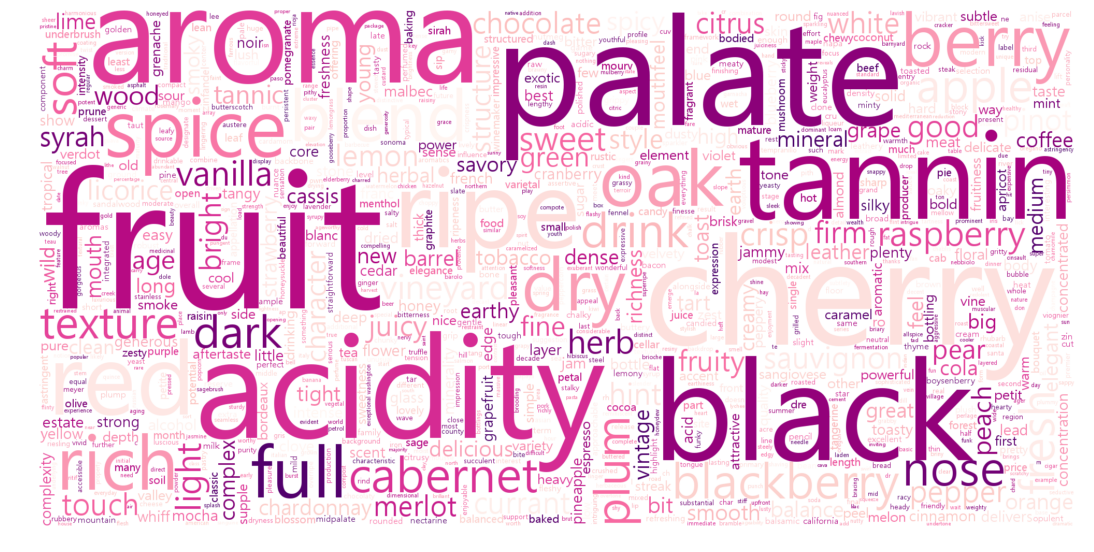

In [44]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator

word_cloud = WordCloud(font_path="C:/Windows/Fonts/malgun.ttf",
                       width=2000, height=1000,
                       max_words=1000,
                       background_color='white').generate_from_frequencies(wine_word_dic)

plt.figure(figsize=(15,15))

plt.imshow(word_cloud.recolor(colormap='RdPu'), interpolation='bilinear')

plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

---
> <span style='font-size:20pt;'>전체 데이터의 60%만 사용</span>
---
- 메모리 부족 현상을 해결하기 위해서, 더 적은 데이터를 활용하기로 했습니다.
- 양을 제한 시키지 않으면, TF-IDF 단에서 메모리부족이 생겨서 이렇게 활용했습니다.

In [11]:
wine = wine.iloc[:int(len(wine)*.6)]

---
> <span style='font-size:20pt;'>TF-IDF를 Description에 사용</span>
---

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
review_tfidf = tfidf.fit_transform(wine['description'])

---
> <span style='font-size:20pt;'>Cosine Similarity</span>
---
- </br> 여기서 Garbage Collecter를 사용하지 않으면 메모리가 부족하다는 문제가 생겨서 사용했습니다.
- Garbage Collecter라는 것은 메모리 관리를 위해서 쓰레기값 처리를 위한 모듈입니다.
- 아마도 이렇게 해도 12Gb이상의 메모리가 필요하지 않을까 싶네요.

In [10]:
import gc
from sklearn.metrics.pairwise import cosine_similarity

review_cosin = cosine_similarity(review_tfidf, review_tfidf)
gc.collect()

0

In [18]:
import gc
from sklearn.metrics.pairwise import euclidean_distances

review_euclidean = euclidean_distances(review_tfidf, review_tfidf)
gc.collect()

28

---
> <span style='font-size:20pt;'>유사도 행렬 계산 함수</span>
---
- Country, province, variety는 입력으로 들어온 값과 같지 않은 모든 값을 무시하게끔 작성되었고 같다면 가중치를 주는 방향으로 만들었습니다.
- GC를 사용하는 이유는 이전과 같습니다.
- 결과로는 모든 행을 내림차순으로 정렬되어진 행렬이 넘겨집니다.
- cosine은 값이 증가하면 유사도가 높은 것이고, euclidean은 값이 낮아질수록 유사도가 증가합니다.
- 위와 같은 성질때문에, euclidean은 역수를 취해줬습니다.

In [47]:
def make_wine_similarity(matrix, country, province, variety, method):
    wine_similarity = np.repeat([wine['country'].apply(
            lambda x : 1.2 if x == country else 0)],len(wine),axis=0); gc.collect()
    
    wine_similarity += np.repeat([wine['province'].apply(
            lambda x : 1 if x == province else 0)], len(wine),axis=0); gc.collect()
    
    wine_similarity += np.repeat([wine['variety'].apply(
            lambda x : 1.2 if x == variety else 0)], len(wine),axis=0); gc.collect()
    
    wine_similarity = np.divide(
        wine_similarity, np.repeat([wine['price']], len(wine), axis=0)); gc.collect()
    
    wine_similarity += review_cosin * 1
    if method == 'euclidean':
        wine_similarity = np.divide(np.ones((len(wine),len(wine))), wine_similarity )
    gc.collect()
    
    wine_similarity_reverse = wine_similarity.argsort()[:, ::-1]
    
    return wine_similarity_reverse

---
> <span style='font-size:20pt;'>Find Similarity</span>
---
- 검색된 와인의 이름이 포함된 모든 행을 '검색 대상'으로 잡고, 그와 유사도가 높다고 판단되는 행을 wine DataFrame에서 가져와서 내보냅니다.

In [13]:
def find_title(wine, index, title, top_n=10):
    
    title_index = wine[
            wine['title'].str.contains(title,regex=False)]['title'].index.values
    similarity_index = np.unique(index[title_index, :(top_n)].reshape(-1))
    
    return wine.iloc[similarity_index]

---
> <span style='font-size:20pt;'>값 입력 및 함수 실행, 결과</span>
---
- country, province, variety은 LabelEncoder때문에, Integer로 대체했습니다.
- country = 검색할 나라
- province = 검색할 포도 생산지
- variety = 검샐할 품종
- title = 검색할 제목
- 정확하게는 country, province, variety는 가중치를 준다고 생각하면 되겠습니다.

In [15]:
country = int(input())
province = int(input())
variety = int(input())
title = input()

1
1
1
1+1


In [14]:
similarity = make_wine_similarity=(review_cosin, country, province, variety, 'cosine')
result = find_title(wine,similarity,title)

In [15]:
for le, key in zip(le, keys):
    result[key] = le.inverse_transform(result[key])

In [19]:
result

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,year
0,Spain,year worthy time rate red cabernet sauvignon s...,Rosé,82,18,Catalonia,Penedès,Michael Schachner,1+1=3 2008 Rosé Cabernet Sauvignon (Penedès),Cabernet Sauvignon,1+1=3,2008
1,Spain,dusty citrus fruit mild friendly cava zesty fr...,Brut,87,16,Catalonia,Cava,Michael Schachner,1+1=3 NV Brut Sparkling (Cava),Sparkling Blend,1+1=3,0
2,Spain,apple toast aroma clean direct palate malic ci...,Brut,87,16,Catalonia,Cava,Michael Schachner,1+1=3 NV Brut Sparkling (Cava),Sparkling Blend,1+1=3,0
3,Spain,clean fresh apple aroma citric palate brut nat...,Cygnus Brut Nature Reserva Made With Organic G...,89,20,Catalonia,Cava,Michael Schachner,1+1=3 NV Cygnus Brut Nature Reserva Made With ...,Sparkling Blend,1+1=3,0
4,Spain,clean fresh apple aroma citric palate brut nat...,Cygnus Brut Nature Reserva Made With Organic G...,89,20,Catalonia,Cava,Michael Schachner,1+1=3 NV Cygnus Brut Nature Reserva Made With ...,Sparkling Blend,1+1=3,0
5,Spain,dusty yeasty nose simplistic friendly palate a...,Rosé,86,20,Catalonia,Cava,Michael Schachner,1+1=3 NV Rosé Sparkling (Cava),Sparkling Blend,1+1=3,0
573,Spain,apple aroma dry direct brut nature citric mali...,Gran Reserva Brut Nature,90,40,Catalonia,Cava,Michael Schachner,Agustí Torelló Mata 2010 Gran Reserva Brut Nat...,Sparkling Blend,Agustí Torelló Mata,2010
1029,Argentina,fiery nose red fruit candy palate show good gr...,Colección,85,12,Mendoza Province,Mendoza,Michael Schachner,Alma del Sur 2009 Colección Cabernet Sauvignon...,Cabernet Sauvignon,Alma del Sur,2009
1139,Spain,focused nose purity mineral clean white fruit ...,Privat Laietà Gran Reserva Brut Nature,91,36,Catalonia,Cava,Michael Schachner,Alta Alella 2014 Privat Laietà Gran Reserva Br...,Sparkling Blend,Alta Alella,2014
1144,Spain,light fresh direct white fruit aroma brut natu...,Mirgin Reserva Brut Nature,90,22,Catalonia,Cava,Michael Schachner,Alta Alella 2015 Mirgin Reserva Brut Nature Sp...,Sparkling Blend,Alta Alella,2015


In [26]:
similarity_matrix = make_wine_similarity(review_euclidean, country, province, variety, 'euclidean')
result = find_title(wine, similarity_matrix, title)

In [28]:
for le, key in zip(le, keys):
    result[key] = le.inverse_transform(result[key])

In [29]:
result

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,year
0,Spain,year worthy time rate red cabernet sauvignon s...,Rosé,82,18,Catalonia,Penedès,Michael Schachner,1+1=3 2008 Rosé Cabernet Sauvignon (Penedès),Cabernet Sauvignon,1+1=3,2008
1,Spain,dusty citrus fruit mild friendly cava zesty fr...,Brut,87,16,Catalonia,Cava,Michael Schachner,1+1=3 NV Brut Sparkling (Cava),Sparkling Blend,1+1=3,0
2,Spain,apple toast aroma clean direct palate malic ci...,Brut,87,16,Catalonia,Cava,Michael Schachner,1+1=3 NV Brut Sparkling (Cava),Sparkling Blend,1+1=3,0
3,Spain,clean fresh apple aroma citric palate brut nat...,Cygnus Brut Nature Reserva Made With Organic G...,89,20,Catalonia,Cava,Michael Schachner,1+1=3 NV Cygnus Brut Nature Reserva Made With ...,Sparkling Blend,1+1=3,0
4,Spain,clean fresh apple aroma citric palate brut nat...,Cygnus Brut Nature Reserva Made With Organic G...,89,20,Catalonia,Cava,Michael Schachner,1+1=3 NV Cygnus Brut Nature Reserva Made With ...,Sparkling Blend,1+1=3,0
5,Spain,dusty yeasty nose simplistic friendly palate a...,Rosé,86,20,Catalonia,Cava,Michael Schachner,1+1=3 NV Rosé Sparkling (Cava),Sparkling Blend,1+1=3,0
573,Spain,apple aroma dry direct brut nature citric mali...,Gran Reserva Brut Nature,90,40,Catalonia,Cava,Michael Schachner,Agustí Torelló Mata 2010 Gran Reserva Brut Nat...,Sparkling Blend,Agustí Torelló Mata,2010
901,Argentina,aroma straw dusty apple mild citrus clean whol...,Fincas,87,14,Mendoza Province,Mendoza,Michael Schachner,Alfredo Roca 2015 Fincas Chardonnay (Mendoza),Chardonnay,Alfredo Roca,2015
1111,Spain,peach melon citrus yeasty nose dry brut nature...,Laietà Privat Gran Reserva Brut Nature,88,35,Catalonia,Cava,Michael Schachner,Alta Alella 2010 Laietà Privat Gran Reserva Br...,Sparkling Blend,Alta Alella,2010
1139,Spain,focused nose purity mineral clean white fruit ...,Privat Laietà Gran Reserva Brut Nature,91,36,Catalonia,Cava,Michael Schachner,Alta Alella 2014 Privat Laietà Gran Reserva Br...,Sparkling Blend,Alta Alella,2014


# Appendix) 할려고 하다가 적용못한 것

---
> <span style='font-size:20pt;'>TKinter를 활용한 GUI화(못함)</span>
---
- https://076923.github.io/posts/Python-tkinter-1/

In [36]:
def count1():
    global count
    count += 1
    label.config(text=str(count))

In [45]:
import tkinter

window = tkinter.Tk()

window.title("Wine Recommendation System")
window.geometry("720x480")
window.resizable(True,True)

count = 0

label = tkinter.Label(window, text=str(count))
label.pack()

button = tkinter.Button(window,text='click' , overrelief='solid', width=15,
                        command=count1, repeatdelay=1000, repeatinterval=100)
button.pack()

window.mainloop()